In [1]:
from util import DataPreprocess

0


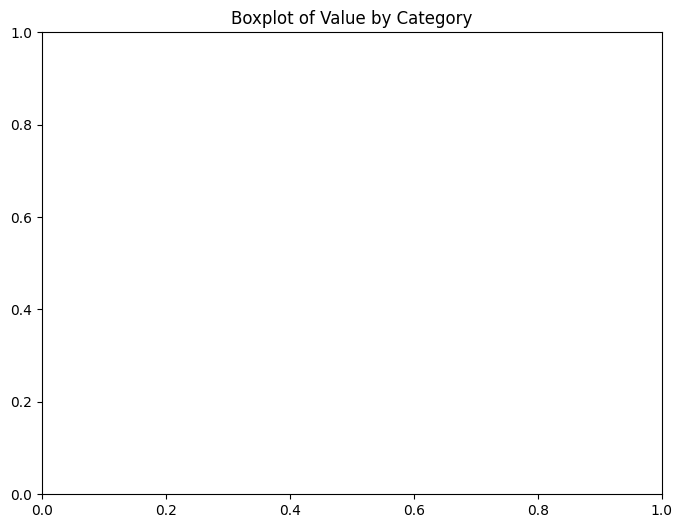

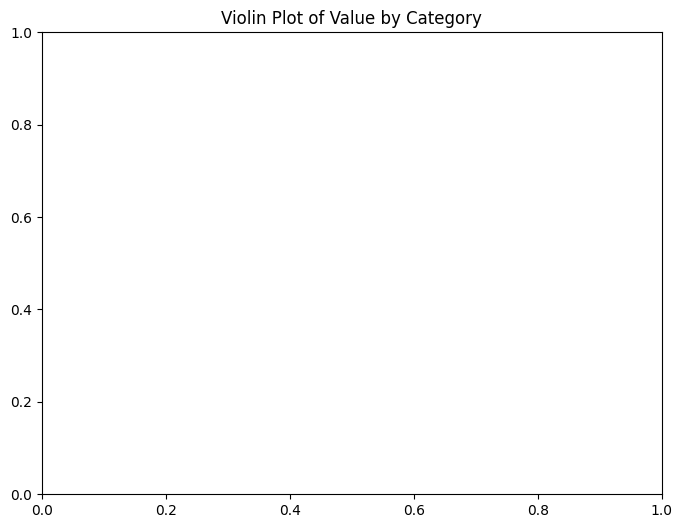

13544


In [2]:
train_file_path = './data/train.csv'


def main():
	DataPreprocess.PreprocessData(train_file_path, './data/processed_train.csv')


if __name__ == '__main__':
	main()